# NRAS_features.ipynb

In this script we study the ligands obtained in "AllBinding.ipynb" in order to optimize the data and create the traning set.

1. With RDKit we obtain some features of the NRas ligands: 
    - Molecular weight 
    - H-bond donor
    - H-bond acceptor
    - TPSA
    - Rotable bonds

2. We discard the molecules that are repeated (with the smiles column).
3. We classify the molecules according to the IC50 to be the target column in the training. 


In [54]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen

df = pd.read_csv('../Data/NRAS_ligands.csv')
print(df.columns)


Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource',
       'IC50 (nM)'],
      dtype='object')


In [55]:
features = []

for i, row in df.iterrows():
    estructura = row['Ligand SMILES']
    
    mol = Chem.MolFromSmiles(estructura)
    
    if mol is not None:
        # Amb les funcions RDKit extreim les dades 
        smiles = row['Ligand SMILES']
        formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
        mw = Descriptors.ExactMolWt(mol)
        logp = Crippen.MolLogP(mol)
        num_hbd = Descriptors.NumHDonors(mol)
        num_hba = Descriptors.NumHAcceptors(mol)
        tpsa = Descriptors.TPSA(mol)
        num_rb = Descriptors.NumRotatableBonds(mol)
        ic50 = row['IC50 (nM)']
        
        # Agregam les dades a una llista
        features.append([smiles, formula, mw, logp, num_hbd, num_hba, tpsa, num_rb, ic50])

# cream un data frame amb les dades extretes
df_features = pd.DataFrame(features, columns=['SMILES','Formula', 'Molecular weight', 'LogP', "H-bond donor","H-bond acceptor","TPSA","Rotatable bonds", "IC50"])

# Guardam el data fram en un nou csv
#df_features.to_csv('../Data/NRAS_ligands_features.csv', index=False)

[20:46:57] Explicit valence for atom # 27 N, 4, is greater than permitted
[20:46:58] Explicit valence for atom # 27 N, 4, is greater than permitted
[20:46:59] Explicit valence for atom # 27 N, 4, is greater than permitted
[20:46:59] Explicit valence for atom # 27 N, 4, is greater than permitted


In [56]:
print(len(df_features))
print(df_features.head(5))

1831
                                              SMILES     Formula  \
0    COc1cc2ncc(-c3cccc(NC4CCNC4)n3)n2cc1-c1cn[nH]c1   C20H21N7O   
1      COc1cc2ncc(-c3cccc(NC4CCNC4)n3)n2cc1-c1cccnc1   C22H22N6O   
2      COc1cc2ncc(-c3cccc(NC4CCNC4)n3)n2cc1-c1ccncc1   C22H22N6O   
3  Cc1n[nH]c(C)c1-c1cn2c(cnc2cc1CO)-c1cccc(NC2CCN...   C22H25N7O   
4  COc1cc2ncc(-c3cccc(NC4CCNC4)n3)n2cc1-c1cnn(CCN...  C26H32N8O2   

   Molecular weight     LogP  H-bond donor  H-bond acceptor    TPSA  \
0        375.180758  2.56880             3                7   92.16   
1        386.185509  3.24070             2                7   76.37   
2        386.185509  3.24070             2                7   76.37   
3        403.212058  2.66934             4                7  103.16   
4        488.264822  2.37440             2               10   93.77   

   Rotatable bonds    IC50  
0                5   33170  
1                5    9920  
2                5    1830  
3                5   15720  
4             

In [57]:
#remove duplicates 
df_smiles = df_features.drop_duplicates(subset=['SMILES'])
print(len(df_smiles))

#guardo les dades 
#df_smiles.to_csv('../Data/SMILES_NRAS_ligands_features.csv', index=False)

#guardo un amb les 50 primeres per fer proves clustering
#df_50 = df_smiles.head(50)
#print(len(df_50))
#df_50.to_csv('../Data/50_NRASligands.csv', index=False)


653


In [58]:
#summary de les variables que he obtingut amb RDKit
 
summary = df_smiles.describe()
print(summary)
#NO FA RESUM DE IC50

       Molecular weight        LogP  H-bond donor  H-bond acceptor  \
count        653.000000  653.000000    653.000000       653.000000   
mean         921.759004    5.772324      2.336907        11.620214   
std          117.814064    1.012752      0.580724         1.405409   
min          299.093773    0.510500      2.000000         5.000000   
25%          903.489462    5.372700      2.000000        11.000000   
50%          937.452031    5.883300      2.000000        12.000000   
75%          973.578946    6.386100      3.000000        12.000000   
max         1154.630408    8.069200      6.000000        16.000000   

             TPSA  Rotatable bonds  
count  653.000000       653.000000  
mean   167.667443         9.820827  
std     20.722815         1.514772  
min     54.250000         3.000000  
25%    160.040000         9.000000  
50%    171.540000        10.000000  
75%    178.880000        11.000000  
max    254.790000        14.000000  


In [59]:
nombre_columna = 'IC50'

# Verificar si la columna se considera numérica
try:
    pd.to_numeric(df_smiles[nombre_columna])
    es_numerica = True
except ValueError:
    es_numerica = False

# Imprimir el resultado
if es_numerica:
    print(f"La columna '{nombre_columna}' se considera numérica.")
else:
    print(f"La columna '{nombre_columna}' no se considera numérica.")

La columna 'IC50' no se considera numérica.


In [60]:
# Convertir la columna a tipo numérico
df_smiles[nombre_columna] = pd.to_numeric(df_smiles[nombre_columna], errors='coerce')

# Verificar si la conversión fue exitosa
if pd.api.types.is_numeric_dtype(df_smiles[nombre_columna]):
    print(f"La columna '{nombre_columna}' se ha convertido a tipo numérico.")
else:
    print(f"No se pudo convertir la columna '{nombre_columna}' a tipo numérico.")

# Guardar el DataFrame actualizado en un nuevo archivo CSV
#df_smiles.to_csv('../Data/NRAS_ligands_features.csv', index=False)


La columna 'IC50' se ha convertido a tipo numérico.


/var/folders/bz/kph7_yt91tx_gtyrx7z046wr0000gn/T/ipykernel_77759/2873619655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_smiles[nombre_columna] = pd.to_numeric(df_smiles[nombre_columna], errors='coerce')


In [61]:
#torno a fer el summary per comprovar que surt el IC50
 
summary = df_smiles.describe()
print(summary)

       Molecular weight        LogP  H-bond donor  H-bond acceptor  \
count        653.000000  653.000000    653.000000       653.000000   
mean         921.759004    5.772324      2.336907        11.620214   
std          117.814064    1.012752      0.580724         1.405409   
min          299.093773    0.510500      2.000000         5.000000   
25%          903.489462    5.372700      2.000000        11.000000   
50%          937.452031    5.883300      2.000000        12.000000   
75%          973.578946    6.386100      3.000000        12.000000   
max         1154.630408    8.069200      6.000000        16.000000   

             TPSA  Rotatable bonds          IC50  
count  653.000000       653.000000    519.000000  
mean   167.667443         9.820827   1430.901734  
std     20.722815         1.514772   3359.693484  
min     54.250000         3.000000      2.000000  
25%    160.040000         9.000000     55.000000  
50%    171.540000        10.000000    550.000000  
75%    178.8

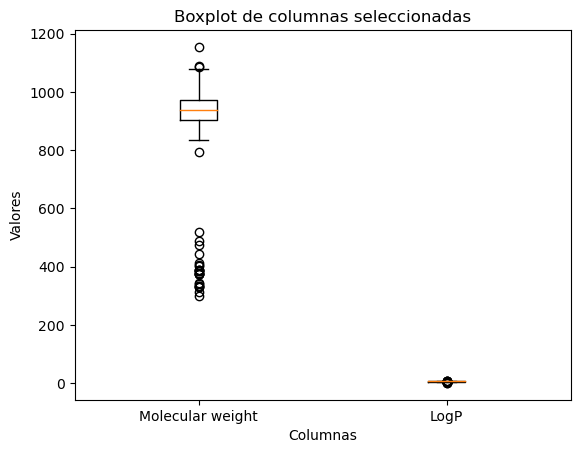

In [67]:
import matplotlib.pyplot as plt

# Seleccionar las dos columnas específicas
columnas_seleccionadas = ['Molecular weight', 'LogP']

# Crear el boxplot utilizando Matplotlib con las columnas seleccionadas
plt.boxplot(df_smiles[columnas_seleccionadas].values)

# Personalizar el boxplot
plt.title('Boxplot de columnas seleccionadas')
plt.xlabel('Columnas')
plt.ylabel('Valores')

# Etiquetas de los ejes X
plt.xticks(range(1, len(columnas_seleccionadas) + 1), columnas_seleccionadas)

# Mostrar el boxplot
plt.show()

In [45]:
#cream un altre columna amb 0/1 segons IC50 si es mes petit del primer quartil (25%) --> 1

import pandas as pd


# Definir función para asignar valores enteros
def asignar_valor(valor, limite):
    
    if valor <= limite:
        classif = 1
    else:
        classif =  0
    print(valor, limite, classif)
    return classif

# Definir el valor límite
limite = 55.

# Aplicar la función a la columna y reemplazar los valores
df_smiles['IC50'] = df_smiles['IC50'].apply(lambda x: asignar_valor(x, limite))

# Mostrar el DataFrame resultante
print(df_smiles)


33170.0 55.0 0
9920.0 55.0 0
1830.0 55.0 0
15720.0 55.0 0
15720.0 55.0 0
4430.0 55.0 0
14820.0 55.0 0
9350.0 55.0 0
16630.0 55.0 0
3720.0 55.0 0
29760.0 55.0 0
4430.0 55.0 0
16630.0 55.0 0
2.0 55.0 1
5580.0 55.0 0
626.0 55.0 0
17640.0 55.0 0
16630.0 55.0 0
20930.0 55.0 0
4290.0 55.0 0
16630.0 55.0 0
1760.0 55.0 0
1880.0 55.0 0
9350.0 55.0 0
55.0 55.0 1
5500.0 55.0 0
nan 55.0 0
55.0 55.0 1
550.0 55.0 0
55.0 55.0 1
550.0 55.0 0
nan 55.0 0
nan 55.0 0
550.0 55.0 0
nan 55.0 0
nan 55.0 0
5500.0 55.0 0
55.0 55.0 1
55.0 55.0 1
55.0 55.0 1
5500.0 55.0 0
nan 55.0 0
550.0 55.0 0
5500.0 55.0 0
550.0 55.0 0
550.0 55.0 0
nan 55.0 0
550.0 55.0 0
nan 55.0 0
550.0 55.0 0
550.0 55.0 0
550.0 55.0 0
550.0 55.0 0
55.0 55.0 1
nan 55.0 0
5500.0 55.0 0
5500.0 55.0 0
55.0 55.0 1
55.0 55.0 1
55.0 55.0 1
nan 55.0 0
nan 55.0 0
nan 55.0 0
55.0 55.0 1
55.0 55.0 1
55.0 55.0 1
55.0 55.0 1
5500.0 55.0 0
550.0 55.0 0
55.0 55.0 1
550.0 55.0 0
nan 55.0 0
nan 55.0 0
55.0 55.0 1
550.0 55.0 0
550.0 55.0 0
550.0 55.0 0
550.0

/var/folders/bz/kph7_yt91tx_gtyrx7z046wr0000gn/T/ipykernel_77759/4066787384.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_smiles['IC50'] = df_smiles['IC50'].apply(lambda x: asignar_valor(x, limite))


(array([424.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 229.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

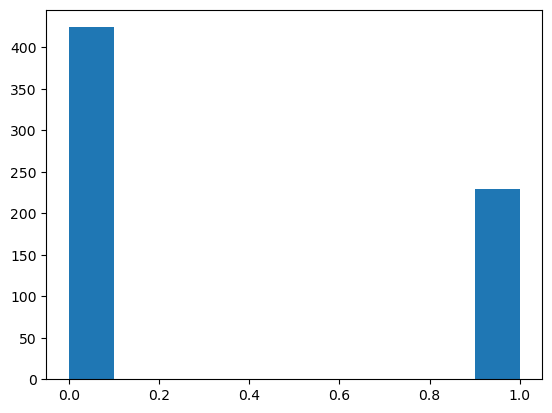

In [46]:
import matplotlib.pyplot as plt
plt.hist(df_smiles.IC50)

In [50]:
df_smiles["IC50"] = pd.to_numeric(df_smiles["IC50"], errors='coerce')

In [52]:
#mask i fer mes amunt perque ara ja no tinc la columna 
#df_smiles = df_smiles.drop(columns = "Formula")

#guardo les dades 

df_smiles.to_csv('../Data/Class_NRAS.csv', index=False)